In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [2]:
n = 10 # number of files
# format n to have 5 number places
files = [f'../preprocessed/events-{str(i).zfill(5)}.pkl' for i in range(1, n+1)]

# Create graph

In [3]:
G = nx.Graph()

## Add nodes

In [4]:
def get_event_features(event):
    info = event['info']
    articleCounts, multiLingInfo, eventDate = info['articleCounts'], info['multiLingInfo'], info['eventDate']
    
    return {
        'articleCounts': articleCounts,
        'multiLingInfo': multiLingInfo,
        'eventDate': eventDate
    }

In [5]:
def get_concept_features(c):
    return {
        'labelEng': c['labelEng'],
        'type': c['type'],
        'uri': c['uri']
    }

In [6]:
def get_id(orig_id, prefix):
    return f"{prefix}_{orig_id}"

In [7]:
for file in files:
    df = pd.read_pickle(file)
    for i, event in df.iterrows():
        info, similar_events = event['info'], event['similarEvents']
        event_id = get_id(info['uri'], 'e')
        
        G.add_node(event_id, **get_event_features(event))
        
        # concepts = info['concepts']
        # for concept in concepts:
        #     concept_id = get_id(concept['id'], 'c')
        #     G.add_node(concept_id, **get_concept_features(concept))
        #     G.add_edge(event_id, concept_id, edge_type='concept', weight=concept['score'])
        
        for similar_event in similar_events:
            similar_id = get_id(similar_event['uri'], 'e')
            G.add_node(similar_id, eventDate=similar_event['eventDate'])
            G.add_edge(event_id, similar_id, edge_type='similar', weight=similar_event['sim'])
        

## Similarity score

We confirmed that the similarity score is symmetric.

In [8]:
# for n1 in G.nodes():
#     for n2 in G.nodes():
#         if n1 == n2:
#             continue
#         if G.has_edge(n1, n2) and G.has_edge(n2, n1):
#             print(n1, n2, G.edges[n1, n2], G.edges[n2, n1])
#             break

## Article count analysis

Average article count, median article count, and standard deviation of article count.

In [9]:
def has_counts(node):
    return 'articleCounts' in node and 'total' in node['articleCounts']

In [10]:
def get_counts(nodes):
    return [G.nodes[n]['articleCounts']['total'] for n in nodes if has_counts(G.nodes[n])]

In [11]:
article_counts = get_counts(G.nodes())

In [12]:
print(f'Events with article counts: {len(article_counts)}')
print(f'Average article count: {np.average(article_counts)}')
print(f'Median article count: {np.median(article_counts)}')
print(f'Standard deviation of article count: {np.std(article_counts)}')


Events with article counts: 7241
Average article count: 11.97624637481011
Median article count: 8.0
Standard deviation of article count: 24.347260743261902


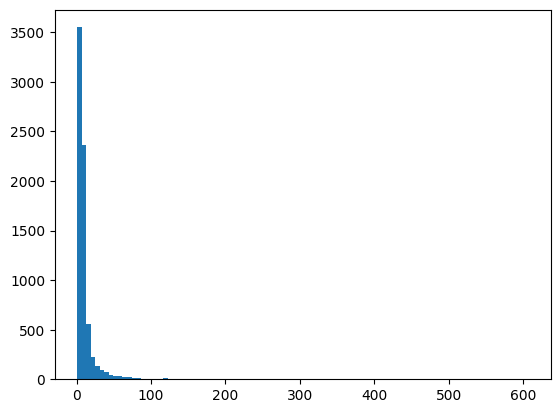

In [13]:
# draw a histogram of article counts
plt.hist(article_counts, bins=100)
plt.show()

Average deviation from the average article count in the neighborhood of a node.

In [14]:
def get_average_article_count_deviation(G, node):
    if not has_counts(G.nodes[node]):
        return -1
    
    neighbors = [ n for n in G.neighbors(node) if has_counts(G.nodes[n]) ]
    if len(neighbors) == 0:
        return -2
    
    counts = get_counts(neighbors)
    return abs(np.average(counts) - G.nodes[node]['articleCounts']['total'])
    

In [15]:
average_article_count_deviations = [ get_average_article_count_deviation(G, n) for n in G.nodes() ]

In [16]:
f_average_article_count_deviations = list(filter(lambda x: x != -1 and x!=-2, average_article_count_deviations))

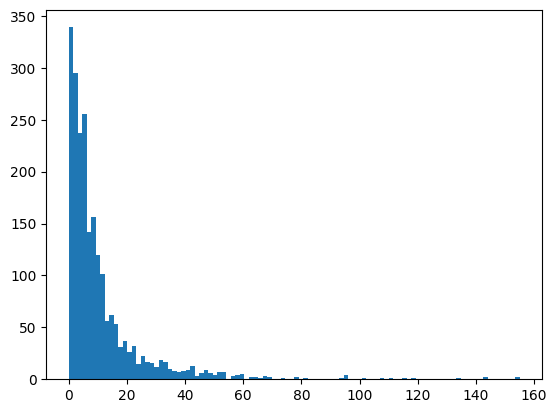

In [17]:
# draw a histogram of average article count deviations
plt.hist(f_average_article_count_deviations, bins=100)
plt.show()

## 

# Most connected node

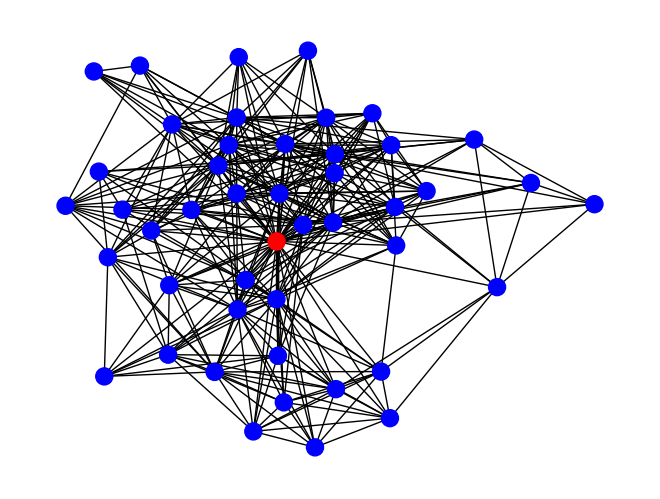

In [18]:
degrees = G.degree()
focus_node = max(degrees, key=lambda x: x[1])[0]
radius = 1

ego = nx.ego_graph(G, focus_node, radius=radius)
node_colors = ["red" if n == focus_node else "blue" for n in ego.nodes()]
pos = nx.spring_layout(ego, seed=42)

nx.draw(ego, pos, node_color=node_colors, node_size=150, with_labels=False)


In [25]:
[G.edges[focus_node, n] for n in G.neighbors(focus_node) if has_counts(G.nodes[n])]


[{'edge_type': 'similar', 'weight': 0.55},
 {'edge_type': 'similar', 'weight': 0.65},
 {'edge_type': 'similar', 'weight': 0.49},
 {'edge_type': 'similar', 'weight': 0.69},
 {'edge_type': 'similar', 'weight': 0.56},
 {'edge_type': 'similar', 'weight': 0.5},
 {'edge_type': 'similar', 'weight': 0.73},
 {'edge_type': 'similar', 'weight': 0.61},
 {'edge_type': 'similar', 'weight': 0.49},
 {'edge_type': 'similar', 'weight': 0.54},
 {'edge_type': 'similar', 'weight': 0.58},
 {'edge_type': 'similar', 'weight': 0.61},
 {'edge_type': 'similar', 'weight': 0.4},
 {'edge_type': 'similar', 'weight': 0.74},
 {'edge_type': 'similar', 'weight': 0.55},
 {'edge_type': 'similar', 'weight': 0.75},
 {'edge_type': 'similar', 'weight': 0.39},
 {'edge_type': 'similar', 'weight': 0.61},
 {'edge_type': 'similar', 'weight': 0.74},
 {'edge_type': 'similar', 'weight': 0.56},
 {'edge_type': 'similar', 'weight': 0.4},
 {'edge_type': 'similar', 'weight': 0.61},
 {'edge_type': 'similar', 'weight': 0.48},
 {'edge_type':

In [24]:
[G.nodes[n] for n in G.neighbors(focus_node) if has_counts(G.nodes[n])]

[{'eventDate': '2013-12-20',
  'articleCounts': {'total': 20, 'deu': 20},
  'multiLingInfo': {'deu': {'summary': 'Nach dem berraschenden Gnadenerlass von Prsident Wladimir Putin hat Russland mit Spannung auf die Freilassung des Kremlkritikers Michail Chodorkowski gewartet. Es war unklar, wann der frhere l-Milliardr das Straflager nahe der Grenze zu Finnland verlassen kann. Der 50-Jhrige wollte nach Angaben seines Pressedienstes zunchst mit seinen Anwlten die von Putin angekndigte Begnadigung beraten. Der scharfe Gegner des Prsidenten sitzt seit mehr als zehn Jahren in Haft. Auch die Freilassung von zwei Mitgliedern der Putin-kritischen Punkband Pussy Riot im Zuge einer Massenamnestie wurde jederzeit erwartet. In Deutschland stie die vllig unerwartete Ankndigung einer Amnestie fr Chodorkowski auf Zustimmu',
    'title': 'Putins Zugeständnis an den Westen - Wann kommt Chodorkowski frei?'}}},
 {'eventDate': '2013-12-20',
  'articleCounts': {'total': 30, 'deu': 30},
  'multiLingInfo': {'de

In [19]:
G.nodes['e_7025']

{'eventDate': '2013-12-21',
 'articleCounts': {'spa': 23, 'total': 46, 'eng': 23},
 'multiLingInfo': {'spa': {'summary': 'Jodorkovski incia su vida de hombre libre en Berlín\nAFP\nBerlín -- El exmagnate del petróleo y opositor al Kremlin Mijail Jodorkovski, que salió de la cárcel tras ser indultado por el presidente de su país, Vladimir Putin, se reencontró con su hijo mayor, Pavel, en Berlín, donde inició este sábado su nueva vida de ...\n Magnate ruso Jodorkovsky se reúne con familiares El Nuevo Herald\nEl opositor ruso Jodorkovski se reencontró con su hijo mayor en Berlín El Universal (Venezuela)\nJodorkovski se \'implicará\' en la liberación de otros presos rusos El Mundo\nRTVE - Los Tiempos - Lainformacion.com\nlos 592 artículos informativos "',
   'title': 'Khodorkovsky begins his life of free man in berlin - mafas'},
  'eng': {'summary': 'The former oil baron Mikhail Khodorkovsky is meeting with his family in Berlin a day after being released from decade-long imprisonment in Rus

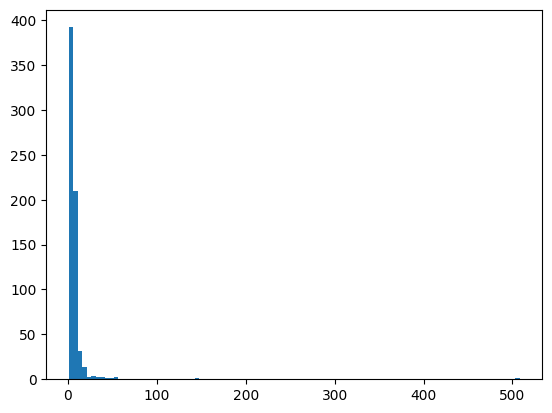

In [20]:
# histogram
plt.hist(get_counts(list(G.neighbors(focus_node))), bins=100)
plt.show()

In [21]:
deviations = [ get_average_article_count_deviation(G, n) for n in list(G.neighbors(focus_node)) ]


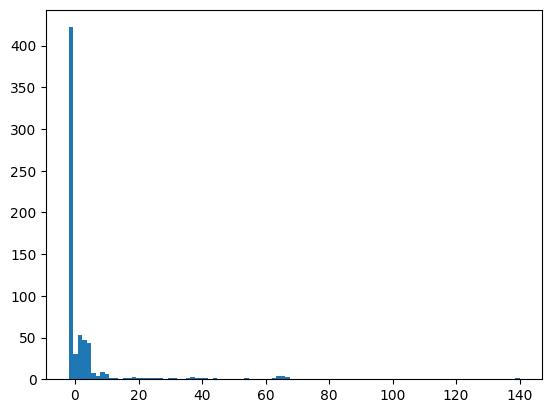

In [22]:
plt.hist(deviations, bins=100)
plt.show()

Is this cheating? The similar events are really all the same event.
It wouldn't be shocking if we only had good performance on events like this, where we're learning on the test data.

# Correlation between article count and average article count in neighborhood

In [23]:
def get_neighbourhood_counts(G, node):
    if not has_counts(G.nodes[node]):
        return -1, -1
    
    neighbors = [ n for n in G.neighbors(node) if has_counts(G.nodes[n]) ]
    if len(neighbors) == 0:
        return -1, -1
    
    node_count = G.nodes[node]['articleCounts']['total']
    counts = get_counts(neighbors)
    return node_count, np.average(counts)

In [24]:
def get_correlation_arrays(G):
    
    node_counts = []
    neigh_counts = []
    for node in G.nodes:
        c, nc = get_neighbourhood_counts(G, node)
        if c == -1:
            continue
        node_counts.append(c)
        neigh_counts.append(nc)
        
    return node_counts, neigh_counts
        

In [25]:
node_counts, neighbourhood_counts = get_correlation_arrays(G)

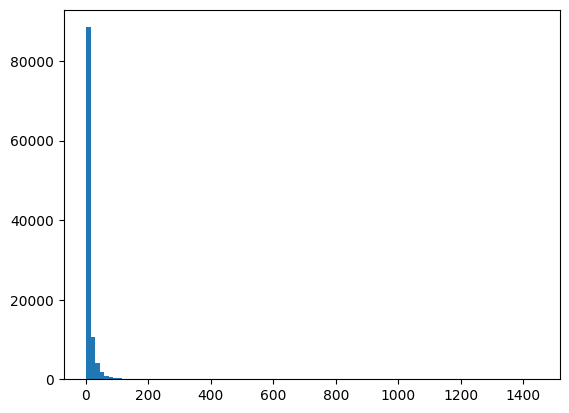

In [26]:
plt.hist(node_counts, bins=100)
plt.show()

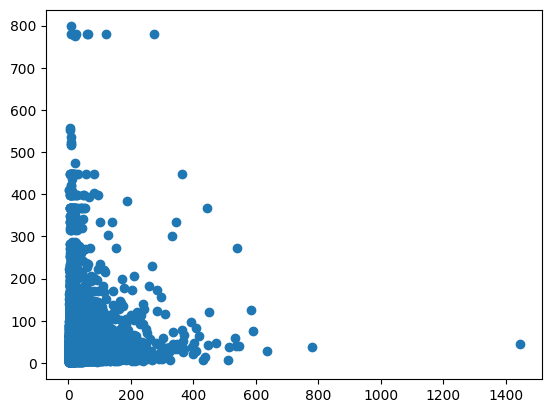

In [27]:
plt.scatter(node_counts, neighbourhood_counts)
plt.show()

In [28]:
pearson_correlation = np.corrcoef(node_counts, neighbourhood_counts)[0, 1]
print(f'Pearson correlation: {round(pearson_correlation, 4)}')

Pearson correlation: 0.1635


A Pearson correlation coefficient of 0.0905 suggests a very weak positive linear relationship between the two sets of data

In [29]:
from scipy.stats import spearmanr, kendalltau
spearman_correlation, _ = spearmanr(node_counts, neighbourhood_counts)
kendall_correlation, _ = kendalltau(node_counts, neighbourhood_counts)

print(f'Spearman correlation: {round(spearman_correlation, 4)}')
print(f'Kendall correlation: {round(kendall_correlation, 4)}')

Spearman correlation: 0.2638
Kendall correlation: 0.1856


These tests do not assume a linear relationship and can capture a wider range of dependencies than Pearson's correlation coefficient. However, the results still indicate only a weak relationship between the two values.

## Two-hop neighborhood

In [30]:
def get_two_hop_neighborhood(G, node, filter=False):
    one_hop = [ n for n in G.neighbors(node) ]
    two_hop = [ n for n in G.neighbors(node) for n in G.neighbors(n)]
    neigh =  list(set(one_hop + two_hop))
    
    if filter:
        return [ n for n in neigh if has_counts(G.nodes[n]) ]
    return neigh

In [31]:
def get_2h_neighbourhood_counts(G, node):
    if not has_counts(G.nodes[node]):
        return -1, -1
    
    neighbors = get_two_hop_neighborhood(G, node, filter=True)
    if len(neighbors) == 0:
        return -1, -1
    
    node_count = G.nodes[node]['articleCounts']['total']
    counts = get_counts(neighbors)
    return node_count, np.average(counts)

In [32]:
get_2h_neighbourhood_counts(G, 'e_7025')

(46, 20.07103825136612)

In [33]:
def get_2h_correlation_arrays(G):
    
    node_counts = []
    neigh_counts = []
    for node in G.nodes:
        c, nc = get_2h_neighbourhood_counts(G, node)
        if c == -1:
            continue
        node_counts.append(c)
        neigh_counts.append(nc)
        
    return node_counts, neigh_counts

In [38]:
node_counts, neighbourhood_counts = get_2h_correlation_arrays(G)

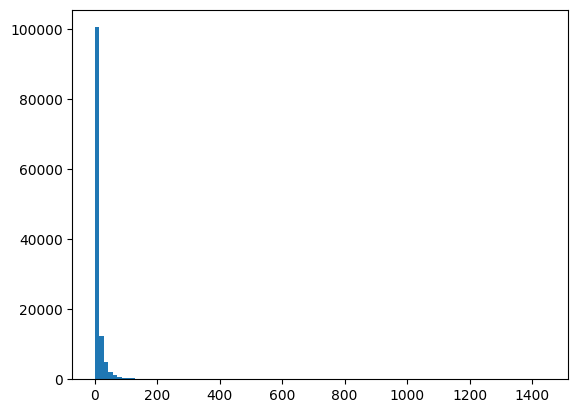

In [35]:
plt.hist(node_counts, bins=100)
plt.show()

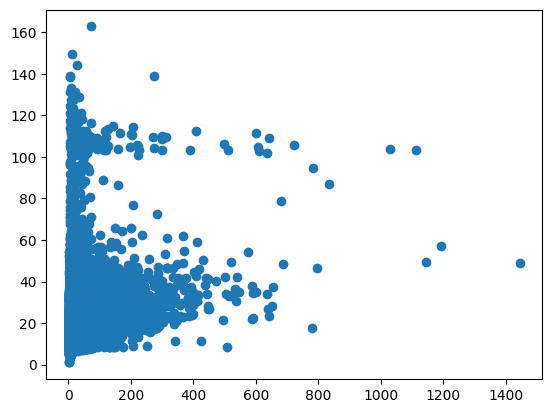

In [36]:
plt.scatter(node_counts, neighbourhood_counts)
plt.show()

In [37]:
pearson_correlation = np.corrcoef(node_counts, neighbourhood_counts)[0, 1]
spearman_correlation, _ = spearmanr(node_counts, neighbourhood_counts)
kendall_correlation, _ = kendalltau(node_counts, neighbourhood_counts)
print(f'Pearson correlation: {round(pearson_correlation, 4)}')
print(f'Spearman correlation: {round(spearman_correlation, 4)}')
print(f'Kendall correlation: {round(kendall_correlation, 4)}')

Pearson correlation: 0.3268
Spearman correlation: 0.3683
Kendall correlation: 0.2615


# TODO: k-hop analysis